In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import plotly.express as px
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.colors as pc
import os
import plotly.graph_objects as go
import plotly.io as pio
from shapely.geometry import Polygon, MultiPolygon
import subprocess
from pathlib import Path

In [3]:
"""
Dynamically find the project root (where .git exists) and set it as the current working directory.
"""
project_root = Path(subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip())
os.chdir(project_root)

In [4]:
df = pd.read_csv('data/knnData/BA_US_knn_text.csv')

(1829363, 10)


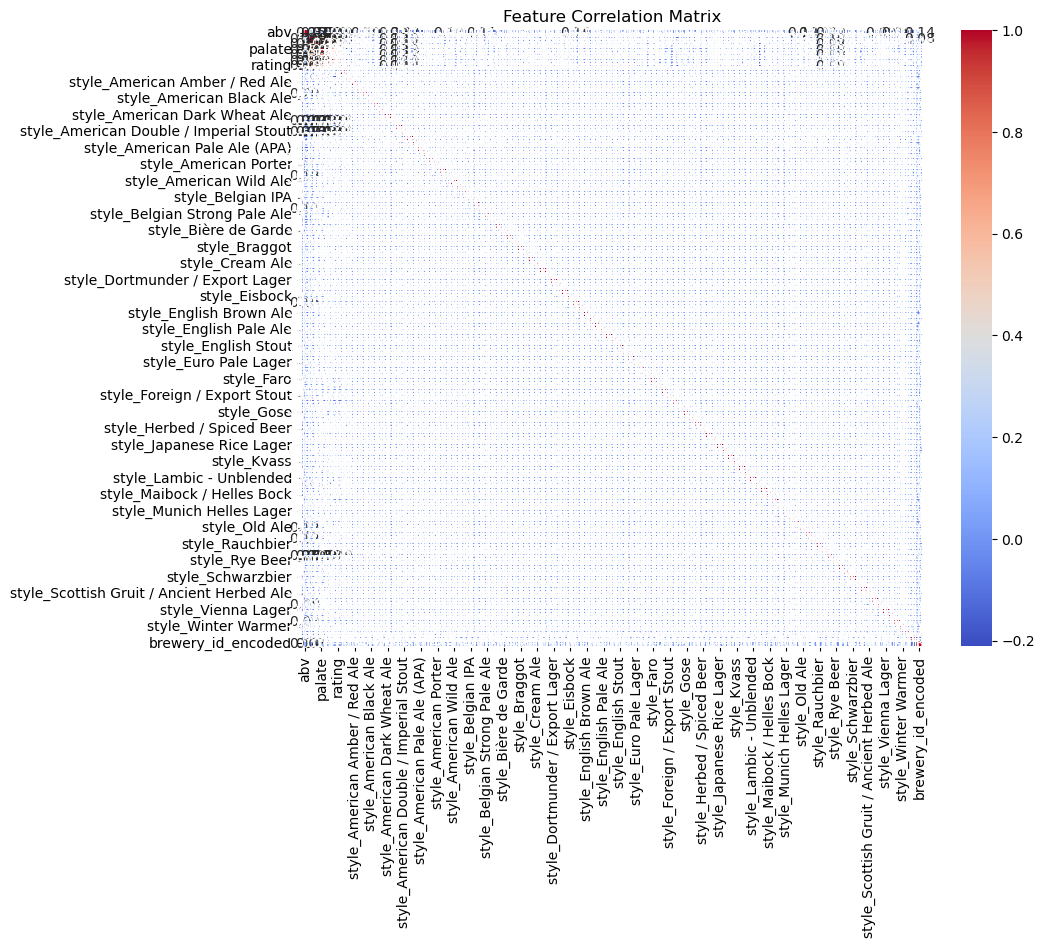

Highly correlated features with correlation > 0.8:
    Feature_1 Feature_2  Correlation
230     aroma    rating     0.857140
342    palate    rating     0.823379
453     taste   overall     0.841406
454     taste    rating     0.957886
564   overall     taste     0.841406
566   overall    rating     0.906449
674    rating     aroma     0.857140
675    rating    palate     0.823379
676    rating     taste     0.957886
677    rating   overall     0.906449
   abv  appearance  taste    rating  style_Altbier  \
0 -0.5         0.0  -0.50 -0.313433            0.0   
1 -0.5        -1.0  -0.75 -1.014925            0.0   
2 -0.5        -2.0  -0.50 -0.955224            0.0   
3 -0.5         0.0   0.00  0.134328            0.0   
4 -0.5         0.0   0.50  0.731343            0.0   

   style_American Adjunct Lager  style_American Amber / Red Ale  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2               

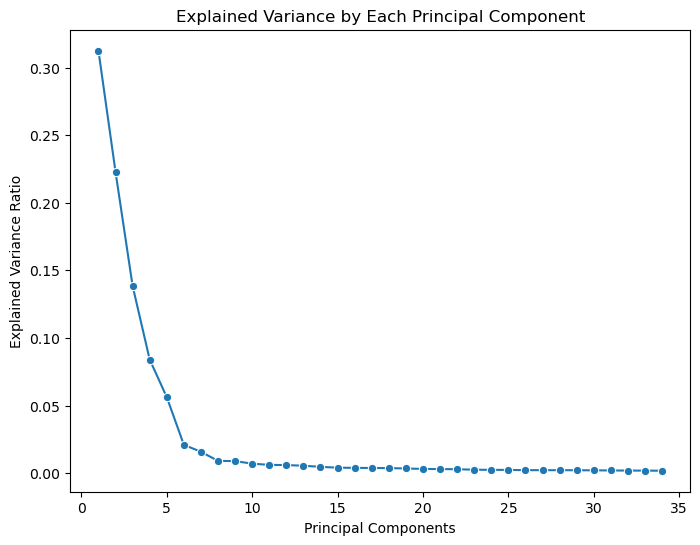

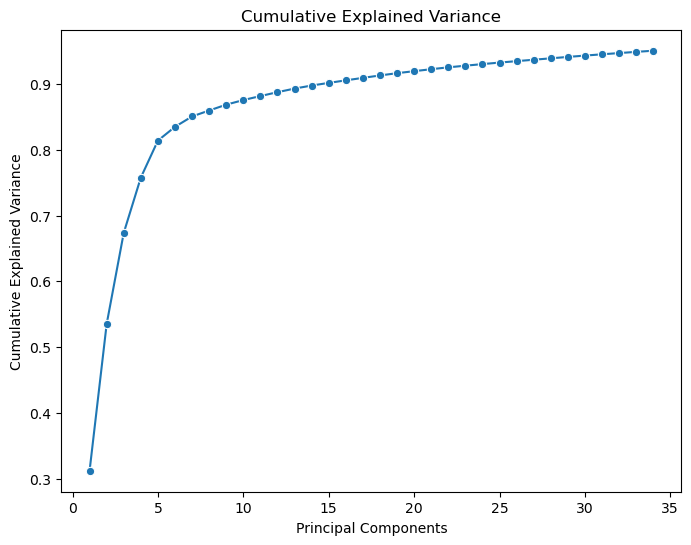

Principal Component 1: ['rating', 'taste', 'appearance']
Principal Component 2: ['user_id_encoded', 'brewery_id_encoded', 'rating']
Principal Component 3: ['brewery_id_encoded', 'user_id_encoded', 'abv']
Principal Component 4: ['abv', 'brewery_id_encoded', 'rating']
Principal Component 5: ['appearance', 'taste', 'rating']
Principal Component 6: ['style_American IPA', 'style_American Double / Imperial IPA', 'style_American Pale Ale (APA)']
Principal Component 7: ['style_American Double / Imperial IPA', 'style_American Double / Imperial Stout', 'style_American IPA']
Principal Component 8: ['style_American Double / Imperial Stout', 'style_American Pale Ale (APA)', 'style_Russian Imperial Stout']
Principal Component 9: ['style_American Pale Ale (APA)', 'style_American Double / Imperial Stout', 'style_Russian Imperial Stout']
Principal Component 10: ['style_American Porter', 'style_American Amber / Red Ale', 'style_Saison / Farmhouse Ale']
Principal Component 11: ['style_American Amber / Re

In [5]:
%run src/questions/dbscan/test/param_selec.ipynb

### Finding the optimal parameters for the clustering

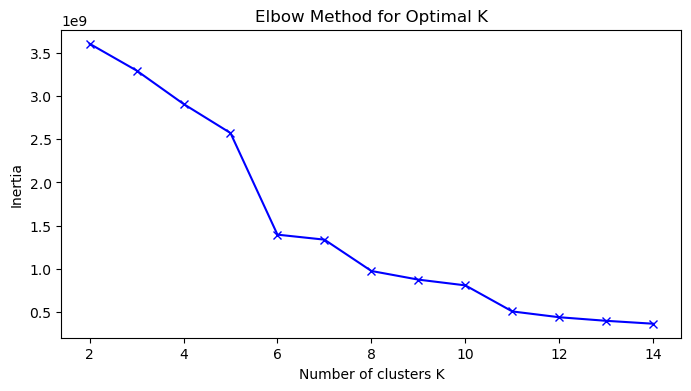

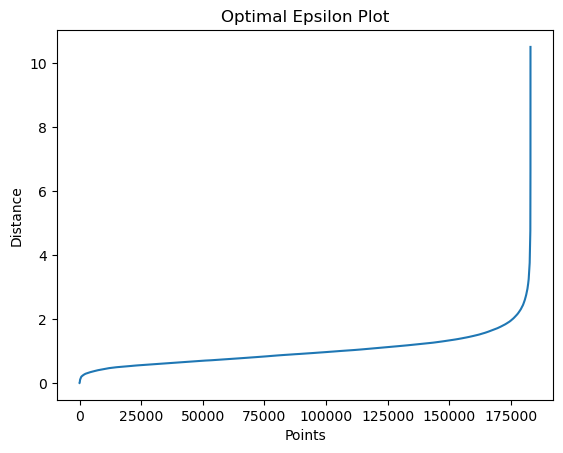

In [6]:
#======================================
#IMPUTATION
#======================================

'''
iter_imputer = IterativeImputer(random_state=42)
X_iter_imputed = pd.DataFrame(iter_imputer.fit_transform(X), columns=X.columns)

print(X_iter_imputed.isnull().sum())
'''
#======================================
#SCALING
#======================================

#scaler = StandardScaler()
scaler = RobustScaler()
#scaler = MinMaxScaler()
#you use this one if the iterative imputer is running
#X_scaled = pd.DataFrame(scaler.fit_transform(X_iter_imputed), columns=X_iter_imputed.columns)
X_scaled = pd.DataFrame(scaler.fit_transform(X_pca_df), columns=X_pca_df.columns)

#======================================
#IMPROVEMENTS ON CLUSTERING
#======================================

#KMEANS
inertia = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

#DBSCAN
X_subset = X_scaled.sample(frac=0.1, random_state=42)  # Use 10% of the data

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_subset)
distances, indices = neighbors_fit.kneighbors(X_subset)

distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.title("Optimal Epsilon Plot")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

### Clustering (Kmeans and DBSCAN)

In [7]:

#======================================
#K MEANS CLUSTERING
#======================================
optimal_k = 6
#kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X_scaled.columns = X_scaled.columns.astype(str)
kmeans = KMeans(n_clusters=optimal_k, n_init=50, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(X_scaled)
X_scaled['cluster_Kmeans'] = cluster_labels_kmeans

#======================================
#DBSCAN
#======================================
X_scaled.columns = X_scaled.columns.astype(str)
dbscan = DBSCAN(eps=1.0, min_samples=5, n_jobs=-1)
cluster_labels_DBSCAN = dbscan.fit_predict(X_scaled)
X_scaled['cluster_DBSCAN'] = cluster_labels_DBSCAN

#======================================
#AGGLOMERATIVE CLUSTERING
#======================================
'''
agglo = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster_labels = agglo.fit_predict(X_scaled)
X_scaled['cluster'] = cluster_labels
'''


"\nagglo = AgglomerativeClustering(n_clusters=5, linkage='ward')\ncluster_labels = agglo.fit_predict(X_scaled)\nX_scaled['cluster'] = cluster_labels\n"

### Visualising the clusters and the state distribution in each cluster

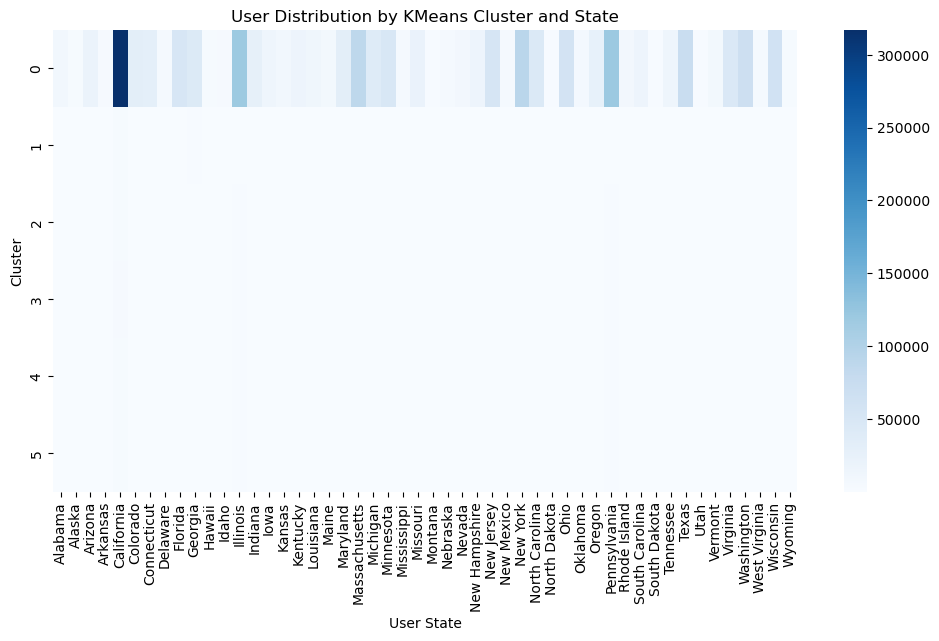

Cluster 0: West Virginia, Nebraska, Montana, Alabama, Wisconsin, Wyoming, Alaska, Maine, North Dakota, New Hampshire
Cluster 1: Arkansas, Georgia, Utah, Oklahoma, Mississippi, South Carolina, Oregon, Wyoming, Vermont, Tennessee
Cluster 2: Louisiana, Idaho, Georgia, Washington, Oregon, Utah, Hawaii, Wisconsin, Mississippi, Colorado
Cluster 3: Utah, Delaware, Maine, Pennsylvania, Virginia, Hawaii, Arizona, North Carolina, Idaho, New York
Cluster 4: Rhode Island, Oklahoma, South Dakota, Massachusetts, Arizona, Ohio, Utah, North Dakota, Missouri, Hawaii
Cluster 5: South Dakota, Minnesota, North Dakota, Nebraska, Iowa, Delaware, Texas, Indiana, Louisiana, Tennessee


/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_72438/2264714602.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_df, x='cluster_state', y='percentage', palette="viridis")


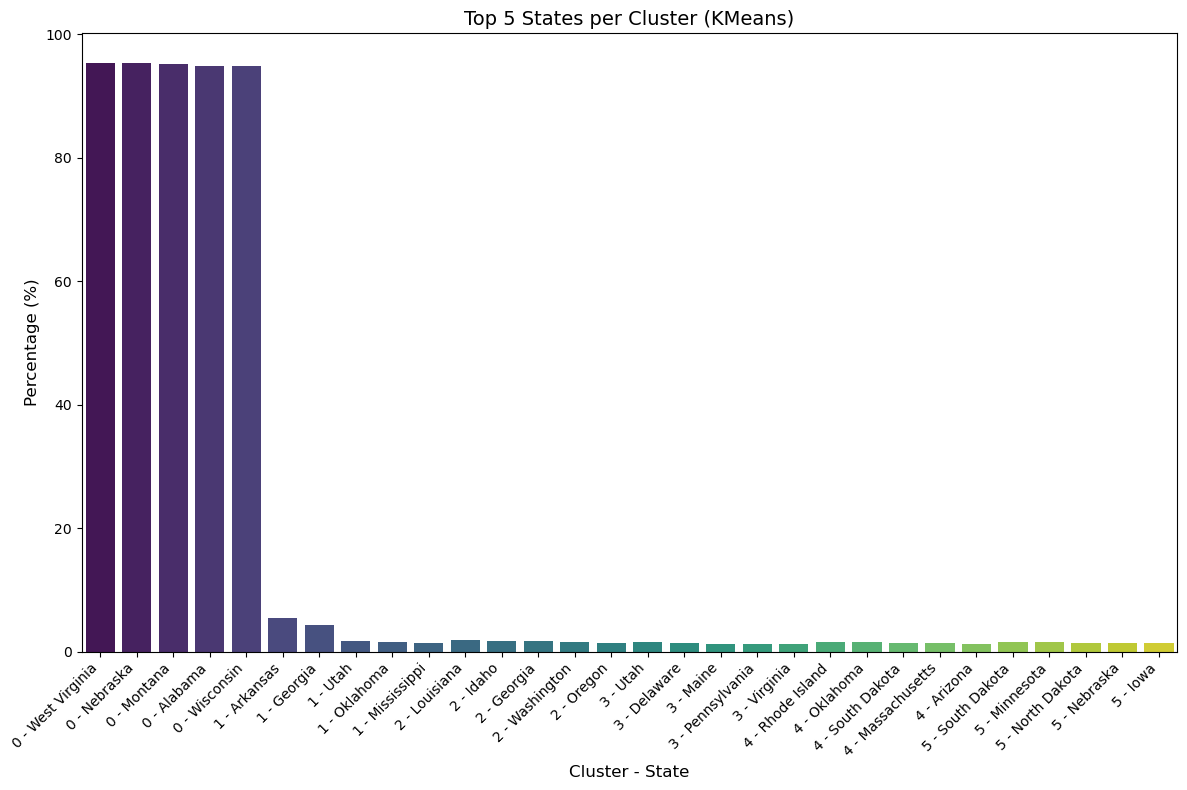

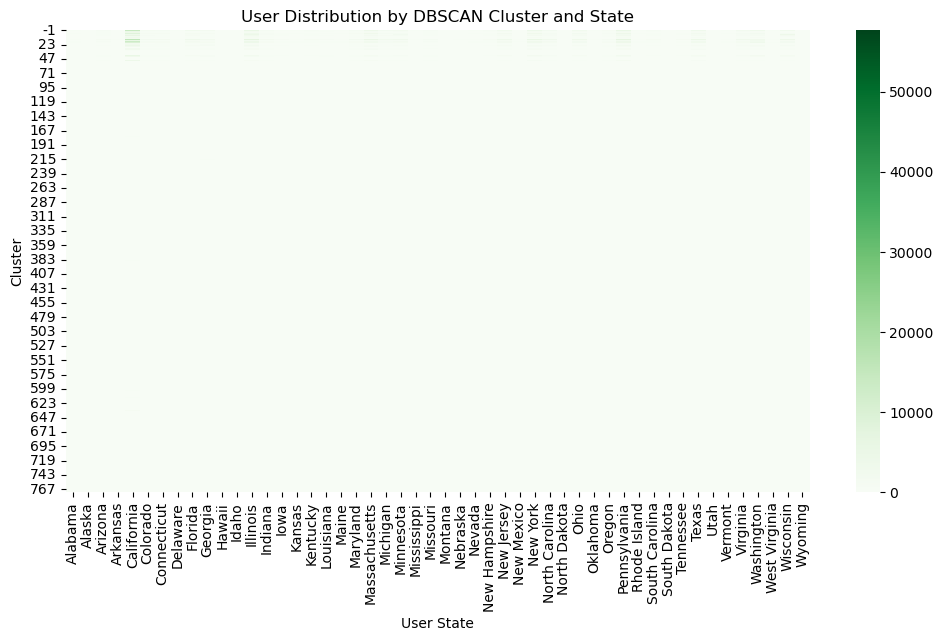

Cluster -1: Delaware, Montana, Oklahoma, South Dakota, Washington, Michigan, Rhode Island, Wyoming, Arizona, California
Cluster 0: New Mexico, Massachusetts, Washington, Montana, New Hampshire, Rhode Island, Alaska, New Jersey, Oregon, California
Cluster 1: Wyoming, Alaska, Louisiana, Oregon, Utah, Colorado, Montana, Vermont, Arizona, Kentucky
Cluster 2: Wisconsin, Illinois, Iowa, Vermont, Wyoming, Minnesota, Montana, Utah, South Dakota, Rhode Island
Cluster 3: Utah, Delaware, Maine, Virginia, Pennsylvania, Idaho, Arizona, Hawaii, North Carolina, New York
Cluster 4: Maine, Hawaii, Utah, Alaska, Massachusetts, Idaho, Connecticut, Rhode Island, Delaware, New Hampshire
Cluster 5: Wisconsin, Minnesota, New Hampshire, West Virginia, Montana, Illinois, Connecticut, Rhode Island, South Dakota, Iowa
Cluster 6: Wisconsin, Minnesota, Illinois, Iowa, Indiana, Alaska, South Dakota, Missouri, Montana, Colorado
Cluster 7: Minnesota, North Dakota, South Dakota, Iowa, Tennessee, Nebraska, Missouri, Lo

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_72438/2264714602.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_df, x='cluster_state', y='percentage', palette="viridis")


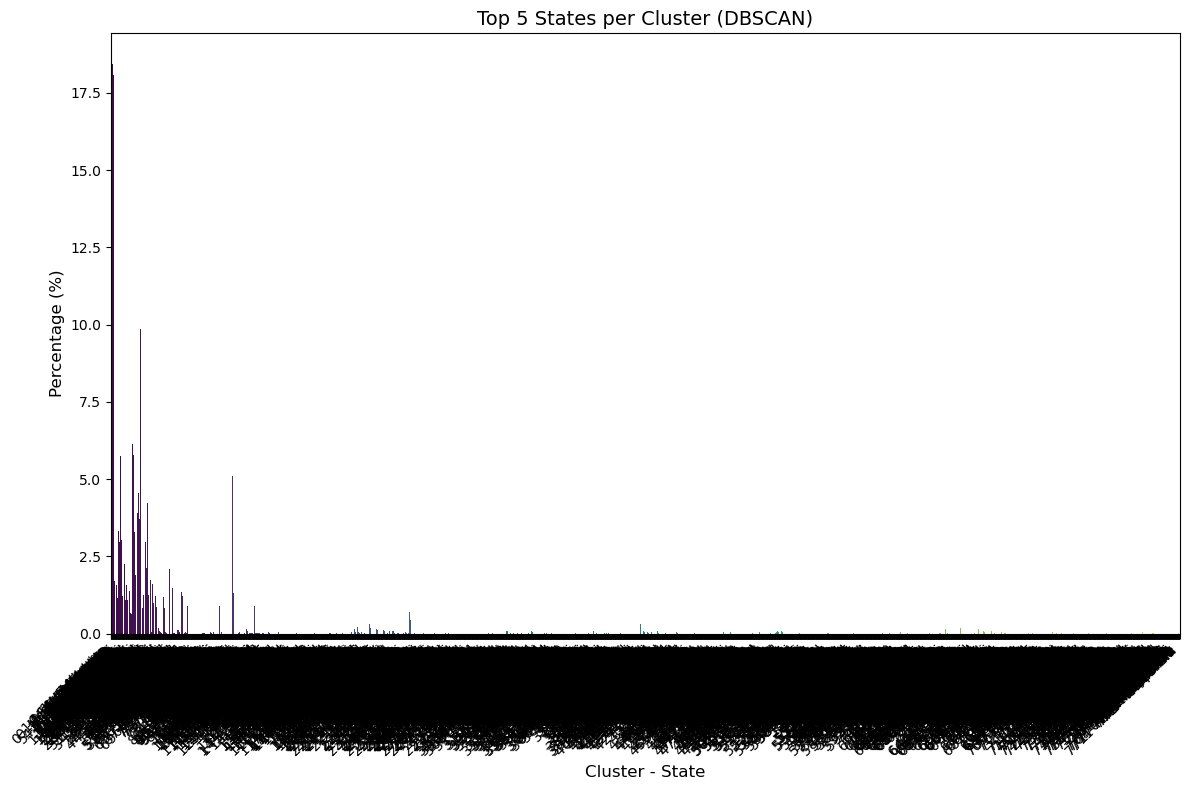

In [8]:
cluster_labels_df = X_scaled[['cluster_Kmeans', 'cluster_DBSCAN']].reset_index(drop=True)
cluster_labels_df['user_id'] = df.loc[X_pca_df.index, 'user_id'].values
cluster_labels_df['beer_id'] = df.loc[X_pca_df.index, 'beer_id'].values

cluster_labels_df = cluster_labels_df.merge(df[['user_id', 'user_state']].drop_duplicates(), on='user_id', how='left')
if 'beer_id' in df.columns:
    cluster_labels_df = cluster_labels_df.merge(df[['beer_id', 'beer_state']].drop_duplicates(), on='beer_id', how='left')

#======================================
# PLOTS: HEATMAP AND BAR PLOTS FOR BOTH CLUSTERS
#======================================
def plot_heatmap(cluster_column, title, cmap):
    user_cluster_state_counts = cluster_labels_df.groupby([cluster_column, 'user_state']).size().unstack(fill_value=0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(user_cluster_state_counts, annot=False, fmt='d', cmap=cmap)
    plt.title(title)
    plt.xlabel('User State')
    plt.ylabel('Cluster')
    plt.show()

def plot_bar_top_states(cluster_column, cluster_method):
    user_cluster_state_counts_t = cluster_labels_df.groupby([cluster_column, 'user_state']).size().unstack(fill_value=0).T
    state_totals = user_cluster_state_counts_t.sum(axis=1)
    normalized_cluster_data = user_cluster_state_counts_t.div(state_totals, axis=0)

    top_5_data = []
    for cluster_label, cluster_data in normalized_cluster_data.items():
        top_states = cluster_data.nlargest(5).index
        top_values = cluster_data.nlargest(5).values
        top_5_data.append(pd.DataFrame({
            'state': top_states,
            'percentage': top_values * 100,
            'cluster': cluster_label
        }))
        top_states = cluster_data.nlargest(10).index
        print(f"Cluster {cluster_label}: {', '.join(top_states)}")
    top_5_df = pd.concat(top_5_data)
    top_5_df['cluster_state'] = top_5_df['cluster'].astype(str) + " - " + top_5_df['state']

    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_5_df, x='cluster_state', y='percentage', palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top 5 States per Cluster ({cluster_method})", fontsize=14)
    plt.xlabel("Cluster - State", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.tight_layout()
    plt.show()

# KMeans Heatmap and Bar Plot
plot_heatmap('cluster_Kmeans', 'User Distribution by KMeans Cluster and State', 'Blues')
plot_bar_top_states('cluster_Kmeans', 'KMeans')

# DBSCAN Heatmap and Bar Plot
plot_heatmap('cluster_DBSCAN', 'User Distribution by DBSCAN Cluster and State', 'Greens')
plot_bar_top_states('cluster_DBSCAN', 'DBSCAN')


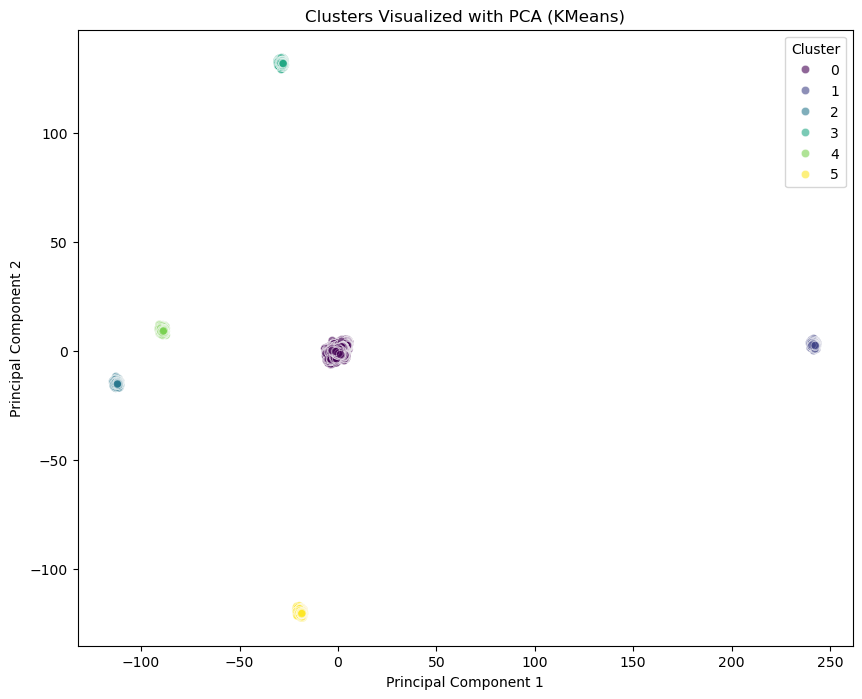

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_72438/371745840.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster')


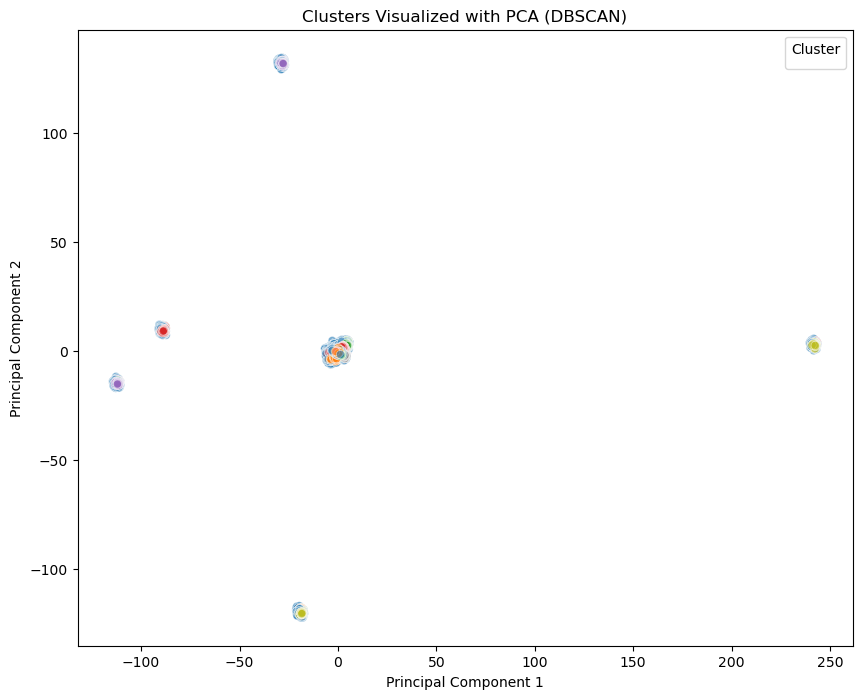

In [9]:
#======================================
# PCA VISUALIZATION FOR BOTH CLUSTERS
#======================================
features = X_scaled.drop(columns=['cluster_Kmeans', 'cluster_DBSCAN'])
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# KMeans PCA Visualization
pca_df['Cluster'] = X_scaled['cluster_Kmeans']
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=pca_df, alpha=0.6)
plt.title('Clusters Visualized with PCA (KMeans)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# DBSCAN PCA Visualization
pca_df['Cluster'] = X_scaled['cluster_DBSCAN']
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='tab10', data=pca_df, alpha=0.6, legend = False)
plt.title('Clusters Visualized with PCA (DBSCAN)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### Getting single maps

        state  cluster_idx    color
0     alabama            1  #f77189
1      alaska            1  #f77189
2     arizona            4  #36ada4
3    arkansas            2  #bb9832
4  california            0    white


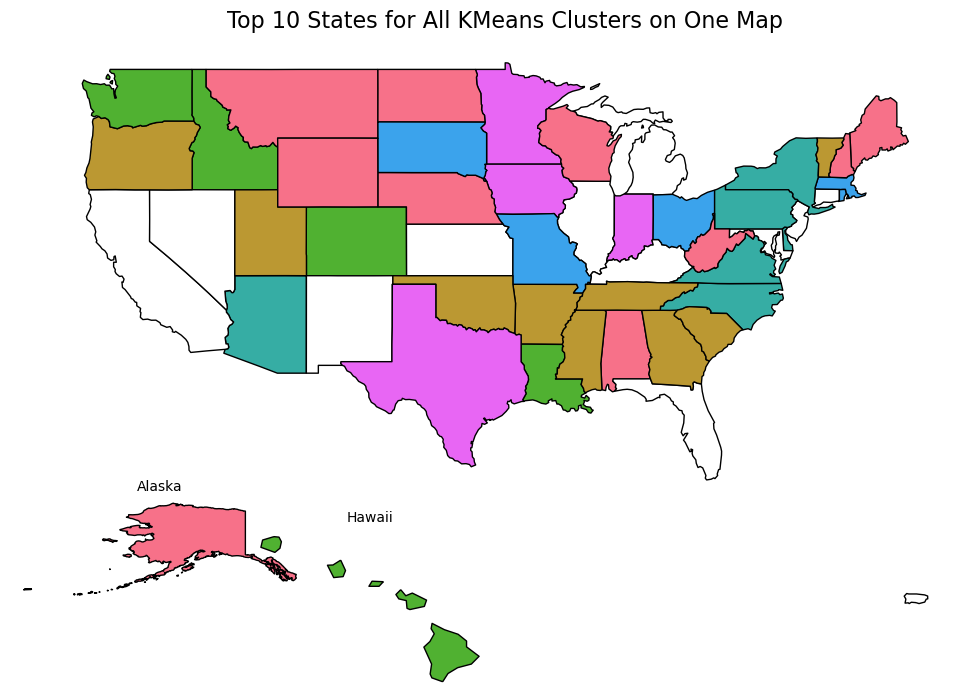

        state  cluster_idx    color
0     alabama           12  #f35cf4
1      alaska            1  #f77189
2     arizona            0    white
3    arkansas           11  #b486f4
4  california            0    white


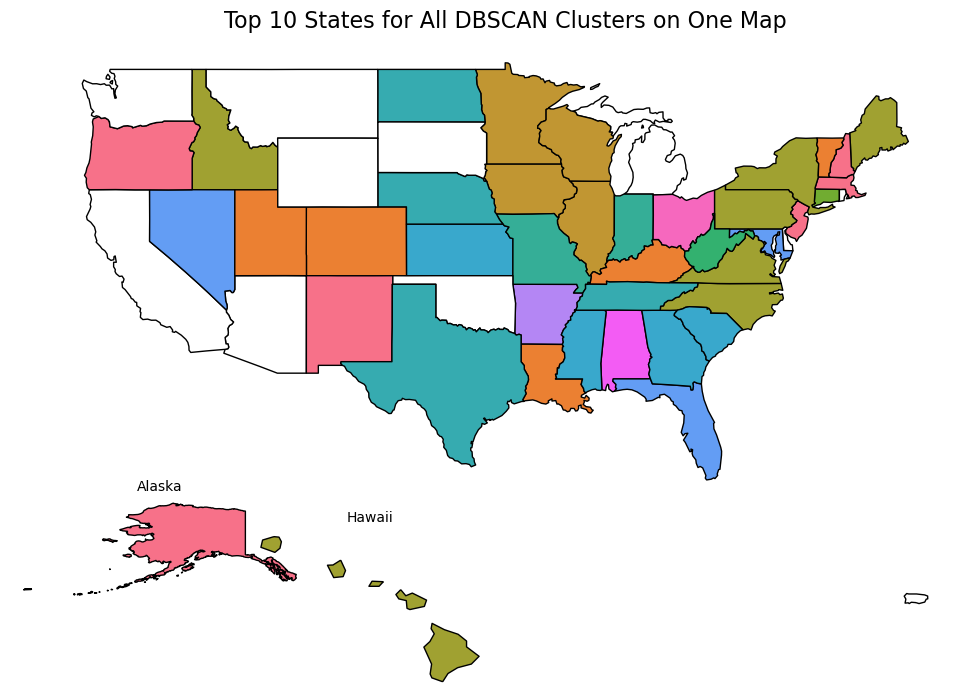

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
from matplotlib.colors import to_hex

pio.renderers.default = 'notebook_connected'

# Load and prepare the us_map as before
us_map = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")
us_map.rename(columns={'name': 'state'}, inplace=True)
us_map['state'] = us_map['state'].str.lower().str.strip()
us_map = us_map.to_crs(epsg=4326)  # Ensure correct coordinate system

#======================================
# FUNCTION TO GET TOP 10 STATES PER CLUSTER
#======================================
def get_top_10_states(cluster_column):
    user_cluster_state_counts_t = cluster_labels_df.groupby([cluster_column, 'user_state']).size().unstack(fill_value=0).T
    state_totals = user_cluster_state_counts_t.sum(axis=1)
    normalized_cluster_data = user_cluster_state_counts_t.div(state_totals, axis=0)

    top_10_states_dict = {}
    for cluster_label, cluster_data in normalized_cluster_data.items():
        top_states = cluster_data.nlargest(10).index.tolist()
        top_10_states_dict[cluster_label] = top_states
    return top_10_states_dict

top_10_states_kmeans = get_top_10_states('cluster_Kmeans')
top_10_states_kmeans_lower = {
    c_label: [state.lower() for state in states]
    for c_label, states in top_10_states_kmeans.items()
}

top_10_states_dbscan = get_top_10_states('cluster_DBSCAN')
top_10_states_dbscan_lower = {
    c_label: [state.lower() for state in states]
    for c_label, states in top_10_states_dbscan.items()
}

#======================================
# FUNCTION TO PREPARE DATA FOR PLOTTING
#======================================
def prepare_plot_data(top_10_dict_lower, us_map):
    all_top_states_map = {}
    for c_label, states in top_10_dict_lower.items():
        for s in states:
            if s not in all_top_states_map:
                all_top_states_map[s] = c_label

    plot_gdf = us_map.copy()
    plot_gdf['cluster'] = plot_gdf['state'].apply(lambda x: all_top_states_map.get(x, -1))

    unique_clusters = sorted([c for c in plot_gdf['cluster'].unique() if c != -1])
    n_clusters = len(unique_clusters)

    cluster_map = {cl: i+1 for i, cl in enumerate(unique_clusters)}
    cluster_map[-1] = 0
    plot_gdf['cluster_idx'] = plot_gdf['cluster'].map(cluster_map)
    return plot_gdf, n_clusters

def plot_with_insets(plot_gdf, n_clusters, title):
    if 'cluster_idx' not in plot_gdf.columns:
        raise KeyError("The 'cluster_idx' column is missing from the GeoDataFrame. Ensure the data preparation step is correct.")

    colors = ['white'] + [to_hex(c) for c in sns.color_palette('husl', n_clusters)]

    color_mapping = {idx: colors[idx] for idx in range(n_clusters + 1)}

    plot_gdf['color'] = plot_gdf['cluster_idx'].map(color_mapping)

    print(plot_gdf[['state', 'cluster_idx', 'color']].head())

    mainland = plot_gdf[~plot_gdf['state'].isin(['alaska', 'hawaii'])]
    alaska = plot_gdf[plot_gdf['state'] == 'alaska'].copy()
    hawaii = plot_gdf[plot_gdf['state'] == 'hawaii'].copy()

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    mainland.plot(color=mainland['color'], edgecolor='black', ax=ax)
    ax.set_title(title, fontsize=16)
    ax.axis('off')

    if not alaska.empty:
        alaska['geometry'] = alaska['geometry'].scale(0.35, 0.35, origin=(0, 0)).translate(xoff=-35, yoff=-15)

        alaska_ax = fig.add_axes([0.1, 0.1, 0.25, 0.25])  # [x, y, width, height]
        alaska.plot(color=alaska['color'], edgecolor='black', ax=alaska_ax)
        alaska_ax.set_title("Alaska", fontsize=10)
        alaska_ax.axis('off')

    if not hawaii.empty:
        hawaii['geometry'] = hawaii['geometry'].scale(0.7, 0.7, origin=(0, 0)).translate(xoff=50, yoff=-20)

        hawaii_ax = fig.add_axes([0.3, 0.05, 0.2, 0.2])  # [x, y, width, height]
        hawaii.plot(color=hawaii['color'], edgecolor='black', ax=hawaii_ax)
        hawaii_ax.set_title("Hawaii", fontsize=10)
        hawaii_ax.axis('off')

    plt.show()
    
#======================================
# FUNCTION TO PLOT USING PLOTLY
#======================================
def plot_static_map(plot_gdf, n_clusters, title):
    colors = ['white'] + [to_hex(c) for c in sns.color_palette('husl', n_clusters)]

    color_mapping = {idx: colors[idx] for idx in range(n_clusters + 1)}

    plot_gdf['color'] = plot_gdf['cluster_idx'].map(color_mapping)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    plot_gdf.plot(color=plot_gdf['color'], edgecolor='black', ax=ax)
    ax.set_title(title, fontsize=16)
    ax.axis('off')  # Remove axes for a clean map
    plt.show()

#======================================
# CREATE A SINGLE MAP FOR ALL KMEANS and DBSCAN CLUSTERS
#======================================
plot_gdf, n_clusters = prepare_plot_data(top_10_states_kmeans_lower, us_map)
plot_with_insets(plot_gdf, n_clusters, "Top 10 States for All KMeans Clusters on One Map")

# Prepare plot data for DBSCAN
plot_gdf, n_clusters = prepare_plot_data(top_10_states_dbscan_lower, us_map)
plot_with_insets(plot_gdf, n_clusters, "Top 10 States for All DBSCAN Clusters on One Map")

### Plotting the state distributions on an interactive map map

you need to show which k is the most optimal => show stats? <br>
you need to add the hover with mouse => % of state in cluster + top features in cluster

(1829363, 10)


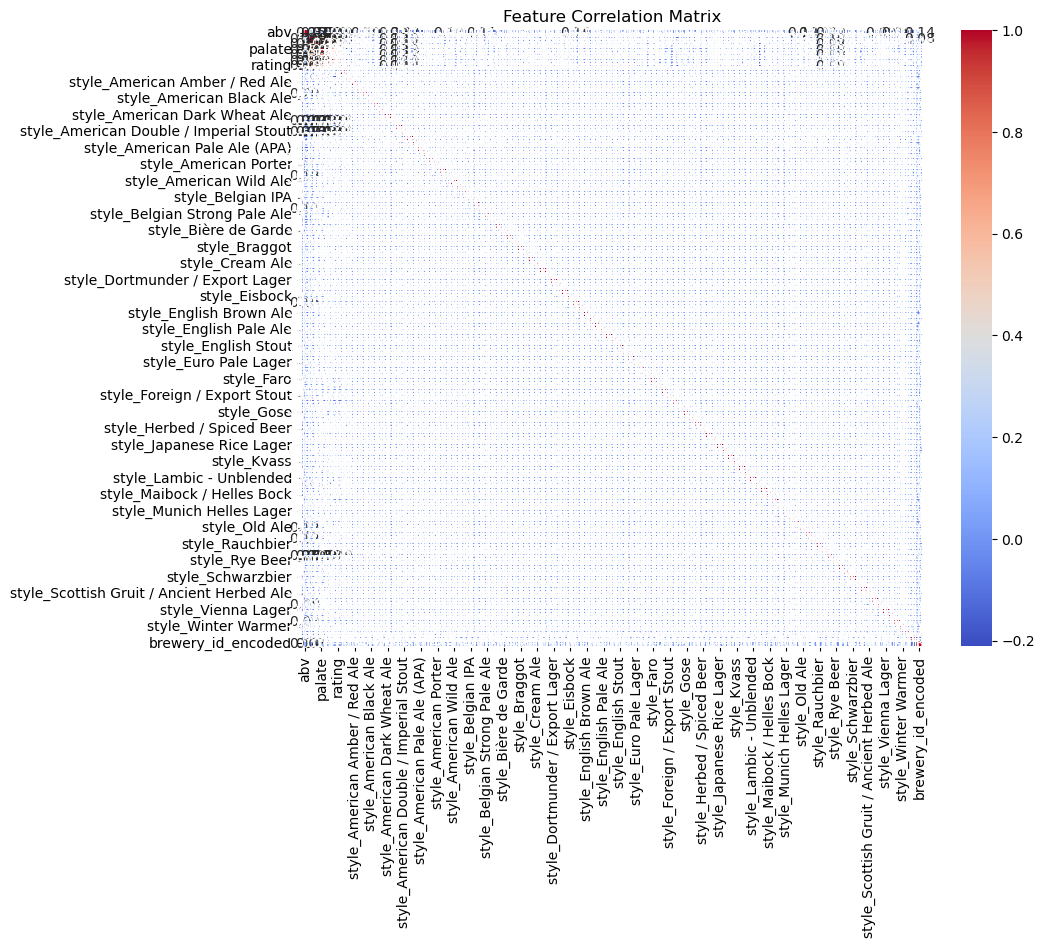

Highly correlated features with correlation > 0.8:
    Feature_1 Feature_2  Correlation
230     aroma    rating     0.857140
342    palate    rating     0.823379
453     taste   overall     0.841406
454     taste    rating     0.957886
564   overall     taste     0.841406
566   overall    rating     0.906449
674    rating     aroma     0.857140
675    rating    palate     0.823379
676    rating     taste     0.957886
677    rating   overall     0.906449
   abv  appearance  taste    rating  style_Altbier  \
0 -0.5         0.0  -0.50 -0.313433            0.0   
1 -0.5        -1.0  -0.75 -1.014925            0.0   
2 -0.5        -2.0  -0.50 -0.955224            0.0   
3 -0.5         0.0   0.00  0.134328            0.0   
4 -0.5         0.0   0.50  0.731343            0.0   

   style_American Adjunct Lager  style_American Amber / Red Ale  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2               

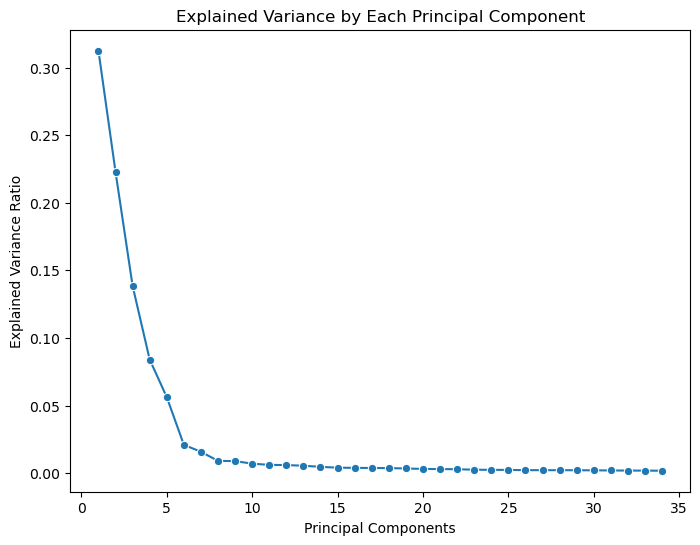

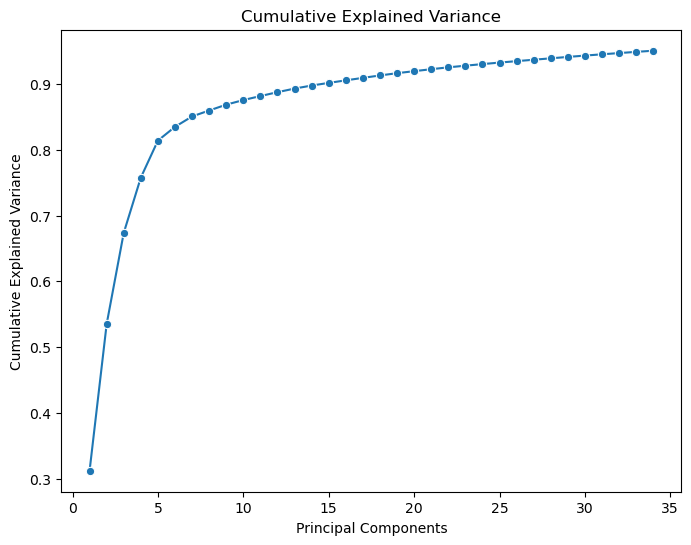

Principal Component 1: ['rating', 'taste', 'appearance']
Principal Component 2: ['user_id_encoded', 'brewery_id_encoded', 'rating']
Principal Component 3: ['brewery_id_encoded', 'user_id_encoded', 'abv']
Principal Component 4: ['abv', 'brewery_id_encoded', 'rating']
Principal Component 5: ['appearance', 'taste', 'rating']
Principal Component 6: ['style_American IPA', 'style_American Double / Imperial IPA', 'style_American Pale Ale (APA)']
Principal Component 7: ['style_American Double / Imperial IPA', 'style_American Double / Imperial Stout', 'style_American IPA']
Principal Component 8: ['style_American Double / Imperial Stout', 'style_American Pale Ale (APA)', 'style_Russian Imperial Stout']
Principal Component 9: ['style_American Pale Ale (APA)', 'style_American Double / Imperial Stout', 'style_Russian Imperial Stout']
Principal Component 10: ['style_American Porter', 'style_American Amber / Red Ale', 'style_Saison / Farmhouse Ale']
Principal Component 11: ['style_American Amber / Re

In [33]:
%run src/questions/dbscan/test/param_selec.ipynb

In [34]:
X_pca_df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-0.403559,-0.423929,-0.928445,-0.332123,0.331993,-0.140588,-0.047128,-0.016731,-0.070423,-0.044114,...,-0.022585,-0.004032,0.004938,0.001855,0.024860,0.020456,0.005616,-0.009943,-0.019304,-0.008218
1,-1.935785,1.493646,-0.259902,-0.179736,-0.209203,-0.094416,-0.008755,-0.001414,-0.068713,-0.030748,...,-0.012127,-0.004456,-0.000711,0.001323,0.017636,0.013694,0.003237,-0.006557,-0.011955,-0.005809
2,-1.729522,-0.844689,-0.787277,-0.074176,-1.201227,-0.076966,-0.019152,-0.004332,-0.065209,-0.029637,...,-0.003189,-0.006623,-0.002276,0.001040,0.014830,0.007952,0.003647,-0.008031,-0.007477,0.001340
3,-0.139464,0.908600,-0.731709,-0.509938,0.004315,-0.145033,-0.046500,-0.020116,-0.074877,-0.045680,...,-0.022141,-0.003392,0.004453,0.003003,0.024846,0.018809,0.006160,-0.008714,-0.018987,-0.009549
4,0.821753,-0.397967,-1.192828,-0.626088,-0.381903,-0.160948,-0.069196,-0.030493,-0.076376,-0.052296,...,-0.022645,-0.003886,0.006133,0.003730,0.026927,0.018424,0.007755,-0.010378,-0.020193,-0.008027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829358,-1.360917,-0.872239,-0.731921,0.311644,0.196728,-0.166466,-0.126723,0.416442,0.823866,0.108940,...,0.012137,-0.002314,0.001554,-0.002939,-0.016321,-0.003852,-0.001112,0.004724,0.007418,0.005212
1829359,-0.421502,-0.501082,-0.978902,-0.415414,-0.461513,-0.137763,-0.048096,-0.020260,-0.083391,-0.047895,...,-0.019874,-0.004366,0.000905,0.002691,0.035939,0.024428,0.010777,-0.011739,-0.024801,-0.006748
1829360,-2.455030,-0.892905,-0.629669,0.073388,0.007916,-0.088066,-0.006766,0.008668,-0.071480,-0.031501,...,-0.018062,-0.007462,-0.001558,0.000448,0.030224,0.023920,0.005160,-0.014696,-0.023481,-0.006730
1829361,-4.140729,-1.428024,-0.362773,0.513999,0.978238,-0.066399,0.008360,0.006342,-0.068102,-0.023364,...,-0.003592,-0.001814,-0.007213,-0.004246,0.026810,0.024605,0.008970,-0.002274,-0.010903,0.003356


In [35]:
pio.renderers.default = 'notebook'
us_map = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")
us_map.rename(columns={'name': 'state'}, inplace=True)
us_map['state'] = us_map['state'].str.lower().str.strip()
us_map = us_map.to_crs(epsg=4326)  # Ensure correct coordinate system

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_pca_df), columns=X_pca_df.columns)

k_range = range(3, 11) 

top_states_k = []
top_features_k = {}
state_cluster_fractions = {}

for k in k_range:
    X_scaled_copy = X_scaled.copy()

    X_scaled_copy.columns = X_scaled_copy.columns.astype(str)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    cluster_labels_kmeans = kmeans.fit_predict(X_scaled_copy)
    X_scaled_copy['cluster_Kmeans'] = cluster_labels_kmeans
    
    cluster_labels_df = pd.DataFrame({'cluster_Kmeans': cluster_labels_kmeans})
    #cluster_labels_df = X_scaled_copy[['cluster_Kmeans']].reset_index(drop=True)
    cluster_labels_df['user_id'] = df.loc[X_pca_df.index, 'user_id'].values
    cluster_labels_df['beer_id'] = df.loc[X_pca_df.index, 'beer_id'].values

    cluster_labels_df = cluster_labels_df.merge(df[['user_id', 'user_state']].drop_duplicates(), on='user_id', how='left')
    if 'beer_id' in df.columns:
        cluster_labels_df = cluster_labels_df.merge(df[['beer_id', 'beer_state']].drop_duplicates(), on='beer_id', how='left')

    user_cluster_state_counts = cluster_labels_df.groupby(['cluster_Kmeans', 'user_state']).size().unstack(fill_value=0)
    user_cluster_state_counts_t = cluster_labels_df.groupby(['cluster_Kmeans', 'user_state']).size().unstack(fill_value=0).T
    state_totals = user_cluster_state_counts_t.sum(axis=1)
    normalized_cluster_data = user_cluster_state_counts_t.div(state_totals, axis=0)
    state_cluster_fractions[k] = normalized_cluster_data.copy()

    for cluster_label, cluster_data in normalized_cluster_data.items():
        top_states = cluster_data.nlargest(10).index
        print(f"Cluster {cluster_label}: {', '.join(top_states)}")
        top_states_k.append((k, cluster_label, list(top_states)))

    cluster_centers = kmeans.cluster_centers_
    feature_names = X_scaled_copy.columns

    top_features_per_cluster = {}
    for cluster_num in range(k):
        centroid = cluster_centers[cluster_num]
        top_n = 5  
        top_feature_indices = np.argsort(np.abs(centroid))[::-1][:top_n]
        top_feature_names = [feature_names[i] for i in top_feature_indices]
        top_features_per_cluster[cluster_num] = top_feature_names
        print(f"K={k} Cluster {cluster_num}: Top Features: {', '.join(top_feature_names)}")
    
    top_features_k[k] = top_features_per_cluster

#extract top features
#make plot

Cluster 0: Utah, Idaho, Hawaii, Oklahoma, Arizona, Rhode Island, Georgia, Pennsylvania, Washington, Missouri
Cluster 1: Nebraska, North Dakota, Minnesota, West Virginia, Iowa, Wisconsin, Wyoming, Alaska, Texas, Maine
Cluster 2: Arkansas, Georgia, Utah, Oklahoma, Mississippi, South Carolina, Oregon, Wyoming, Vermont, Tennessee
K=3 Cluster 0: Top Features: 27, 25, 29, 28, 24
K=3 Cluster 1: Top Features: 25, 5, 6, 29, 9
K=3 Cluster 2: Top Features: 27, 28, 29, 26, 30
Cluster 0: Nebraska, North Dakota, South Dakota, Minnesota, Wisconsin, Iowa, Wyoming, West Virginia, New Hampshire, Michigan
Cluster 1: Utah, Delaware, Maine, Pennsylvania, Virginia, Hawaii, Arizona, North Carolina, Idaho, New York
Cluster 2: Arkansas, Georgia, Utah, Oklahoma, Mississippi, South Carolina, Oregon, Wyoming, Vermont, Tennessee
Cluster 3: Louisiana, Idaho, Georgia, Washington, Oregon, Utah, Hawaii, Wisconsin, Mississippi, Colorado
K=4 Cluster 0: Top Features: 25, 27, 26, 5, 6
K=4 Cluster 1: Top Features: 25, 27, 

In [36]:
# ----------------------------
# Step 1: Restructure top_states_k
# ----------------------------
top_states_dict = {}
for k, cluster_label, states in top_states_k:
    if k not in top_states_dict:
        top_states_dict[k] = {}
    top_states_dict[k][cluster_label] = [state.lower() for state in states]

# ----------------------------
# Step 2: Define the Color Palette
# ----------------------------
color_palette = px.colors.qualitative.Plotly  # 10 distinct colors
max_clusters = max(len(clusters) for clusters in top_states_dict.values())
if max_clusters > len(color_palette):
    additional_colors = px.colors.qualitative.Alphabet  # Additional distinct colors
    color_palette += additional_colors[:max_clusters - len(color_palette)]

# ----------------------------
# Step 3: Create Interactive Widgets
# ----------------------------
output = widgets.Output()
k_slider = widgets.IntSlider(
    value=3,          # Starting value of k
    min=3,            # Minimum k value
    max=10,           # Maximum k value
    step=1,           # Step size
    description='k:',
    continuous_update=False  # Update only when slider is released
)

# ----------------------------
# Step 4: Define the Update Function
# ----------------------------
def update_map(k):
    with output:
        output.clear_output(wait=True)
        
        cluster_to_states = top_states_dict.get(k, {})
        sorted_clusters = sorted(cluster_to_states.keys())
        
        color_discrete_map = {}
        for i, cluster in enumerate(sorted_clusters):
            color_discrete_map[f'Cluster {cluster}'] = color_palette[i % len(color_palette)]
        color_discrete_map['No Cluster'] = 'white'  # Color for states not in top 10
        
        us_map['cluster'] = 'No Cluster'
        
        for cluster, states in cluster_to_states.items():
            us_map.loc[us_map['state'].isin(states), 'cluster'] = f'Cluster {cluster}'
        
        us_map['state_cap'] = us_map['state'].str.title()
        us_map['name'] = us_map['state_cap']
        
        # ----------------------------
        # Adding the % that belongs to each cluster Popup
        # ----------------------------
        fractions_df = state_cluster_fractions[k].copy()

        if isinstance(fractions_df.columns, pd.MultiIndex):
            fractions_df.columns = fractions_df.columns.droplevel(0)

        fractions_df = fractions_df.reset_index()  # Make 'user_state' a column
        fractions_df['user_state_cap'] = fractions_df['user_state'].str.title()
        cluster_cols = [c for c in fractions_df.columns if c not in ['user_state', 'user_state_cap']]
        for c in cluster_cols:
            fractions_df[c] = fractions_df[c] * 100.0  # convert to %
        
        renamed_cols = {}
        for c in cluster_cols:
            renamed_cols[c] = f"Cluster {c} (%)"
        fractions_df.rename(columns=renamed_cols, inplace=True)

        merged = us_map.merge(fractions_df, left_on='state_cap', right_on='user_state_cap', how='left')
        hover_data = {col: ':.2f' for col in renamed_cols.values()}  # Format with two decimals
        
        # ----------------------------
        # Step 5: Create the Figure
        # ----------------------------
        fig = px.choropleth(
            merged,
            geojson=merged.__geo_interface__,      # GeoJSON data
            locations='name',                      # Column with state names
            color='cluster',                       # Column to color by
            hover_name='name',                     # Hover text: state name
            hover_data=hover_data,                 # Show cluster fractions in hover
            scope="usa",                           # Focus on USA
            color_discrete_map=color_discrete_map, # Mapping of cluster to color
            featureidkey="properties.name"         # Key in GeoJSON to match
        )
        
        #fig.update_geos(fitbounds="locations", visible=False)
        fig.update_geos(
            scope="usa", 
            center=dict(lat=37.0902, lon=-95.7129),  # roughly the geographic center of the continental US
            projection_scale=1.0,  # adjust this value to zoom in or out
            visible=False
        )
        
        fig.update_layout(
            margin={"r":0,"t":30,"l":0,"b":0},
            legend_title="Clusters",
            title_text=f"Top 10 States per Cluster for k={k}",
            title_x=0.5
        )
        
        fig.show()
        directory = "img/question5/"
        fig.write_html(os.path.join(directory, "clustering_by_beer_attributes.html"))

# ----------------------------
# Step 6: Link the Slider to the Update Function
# ----------------------------
def on_k_change(change):
    if change['name'] == 'value':
        update_map(change['new'])

k_slider.observe(on_k_change, names='value')

# ----------------------------
# Step 7: Display the Widgets and Initial Map
# ----------------------------
display(k_slider, output)
update_map(k_slider.value)


IntSlider(value=3, continuous_update=False, description='k:', max=10, min=3)

Output()

### From DBSCAN with eps = 1.5 (Thomas ran)

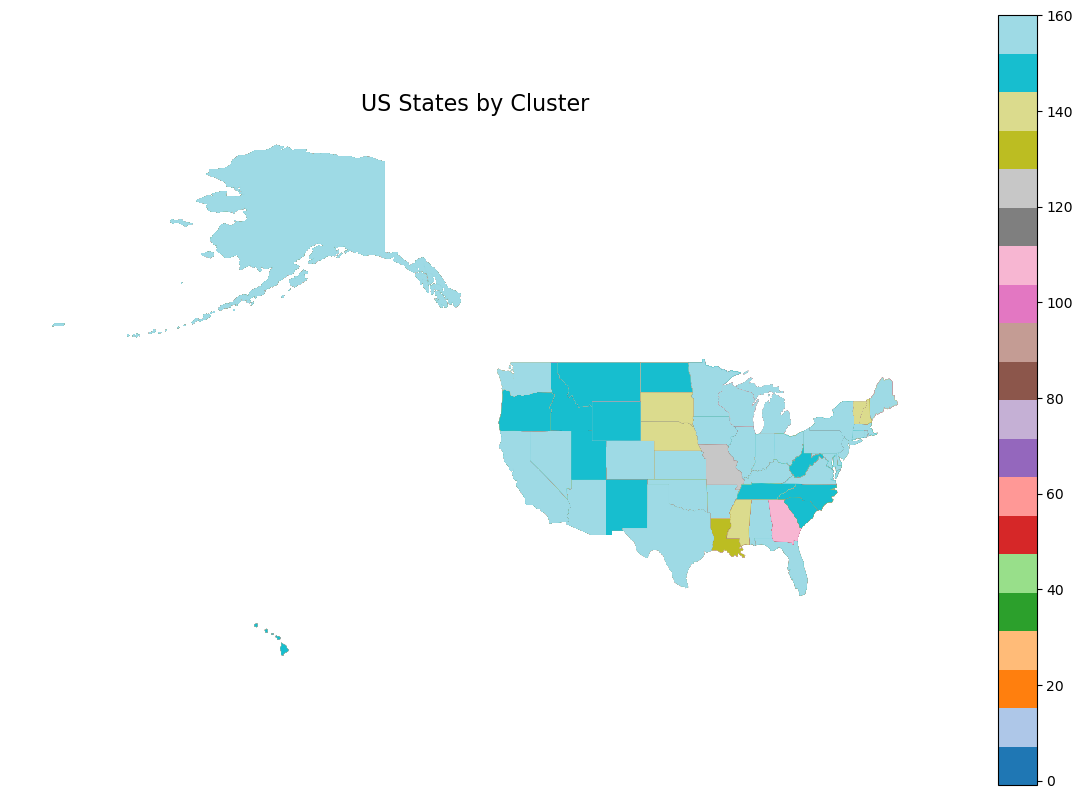

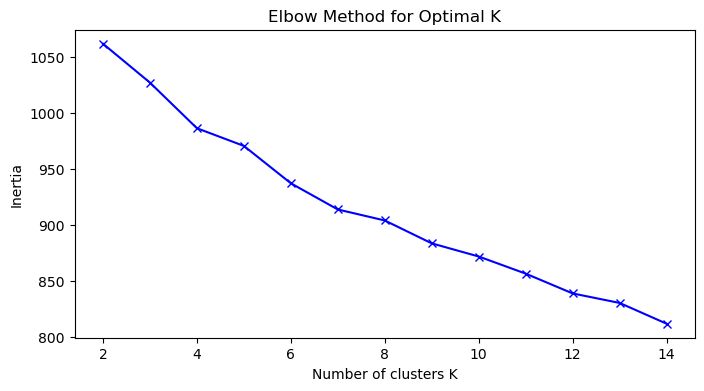

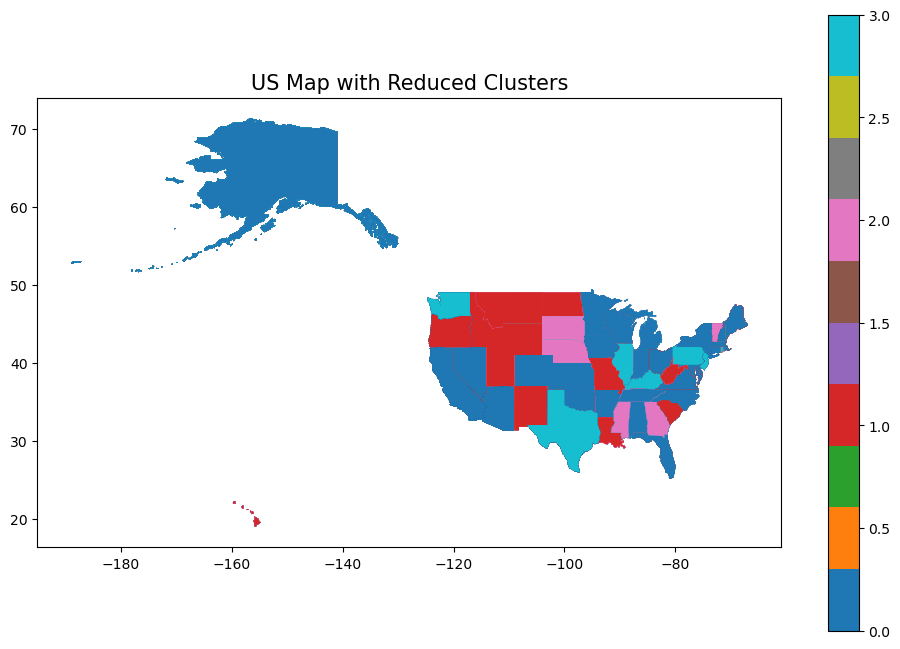

In [ ]:
us_map = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")
us_map.rename(columns={'name': 'state'}, inplace=True)

cluster_data = {
    -1: ['North Dakota', 'Delaware', 'Nebraska', 'Mississippi', 'Arkansas', 'Hawaii', 'Rhode Island', 'Oregon', 'Alabama', 'Vermont'],
    0: ['New Mexico', 'Massachusetts', 'Montana', 'Washington', 'Rhode Island', 'New Hampshire', 'California', 'New Jersey', 'Alaska', 'Oregon'],
    1: ['Wyoming', 'Alaska', 'Louisiana', 'Oregon', 'Colorado', 'Vermont', 'Montana', 'Arizona', 'Utah', 'Pennsylvania'],
    2: ['Montana', 'Hawaii', 'Georgia', 'Colorado', 'Wyoming', 'West Virginia', 'California', 'South Carolina', 'Pennsylvania', 'Utah'],
    3: ['Wisconsin', 'Illinois', 'Montana', 'Iowa', 'Vermont', 'Minnesota', 'Wyoming', 'South Dakota', 'Utah', 'Missouri'],
    4: ['Utah', 'Delaware', 'Maine', 'Virginia', 'Hawaii', 'Pennsylvania', 'Arizona', 'North Carolina', 'Idaho', 'New York'],
    5: ['Hawaii', 'Maine', 'Utah', 'Massachusetts', 'Connecticut', 'Rhode Island', 'Alaska', 'Idaho', 'New Hampshire', 'New York'],
    6: ['Wisconsin', 'Minnesota', 'New Hampshire', 'South Dakota', 'West Virginia', 'Illinois', 'Montana', 'Connecticut', 'Rhode Island', 'Tennessee'],
    7: ['Wisconsin', 'Minnesota', 'Illinois', 'Iowa', 'Indiana', 'Alaska', 'South Dakota', 'Colorado', 'Missouri', 'Montana'],
    8: ['South Dakota', 'Minnesota', 'North Dakota', 'Iowa', 'Texas', 'Louisiana', 'Missouri', 'Tennessee', 'Indiana', 'New Jersey'],
    9: ['South Dakota', 'Wisconsin', 'Iowa', 'North Dakota', 'Nebraska', 'Minnesota', 'Michigan', 'Indiana', 'Illinois', 'Nevada'],
    10: ['South Dakota', 'Utah', 'Wisconsin', 'Minnesota', 'Iowa', 'Illinois', 'West Virginia', 'Nebraska', 'Indiana', 'Oklahoma'],
    11: ['Mississippi', 'Wisconsin', 'Alaska', 'Washington', 'Oregon', 'South Carolina', 'Georgia', 'Iowa', 'Tennessee', 'Florida'],
    12: ['Michigan', 'Nevada', 'Washington', 'West Virginia', 'North Carolina', 'Florida', 'Nebraska', 'Virginia', 'Maryland', 'Texas'],
    13: ['North Dakota', 'Washington', 'Maine', 'Wyoming', 'Idaho', 'Nevada', 'Rhode Island', 'New Hampshire', 'California', 'Alaska'],
    14: ['Mississippi', 'Maine', 'Kentucky', 'West Virginia', 'Tennessee', 'Florida', 'North Dakota', 'Michigan', 'Missouri', 'Iowa'],
    15: ['Arkansas', 'Montana', 'South Dakota', 'Mississippi', 'Utah', 'Louisiana', 'Kansas', 'West Virginia', 'Tennessee', 'North Dakota'],
    16: ['Washington', 'West Virginia', 'Alaska', 'Oregon', 'New Mexico', 'Nebraska', 'Georgia', 'Delaware', 'Montana', 'Florida'],
    17: ['Georgia', 'Alabama', 'South Carolina', 'Tennessee', 'North Carolina', 'Florida', 'Mississippi', 'Delaware', 'Nebraska', 'Idaho'],
    18: ['California', 'New Mexico', 'North Dakota', 'Nevada', 'Hawaii', 'Arizona', 'Idaho', 'Vermont', 'Alaska', 'North Carolina'],
    19: ['Washington', 'Louisiana', 'Idaho', 'West Virginia', 'Oregon', 'Vermont', 'Arizona', 'Montana', 'Tennessee', 'Kentucky'],
    20: ['Wisconsin', 'Utah', 'Kansas', 'California', 'Arkansas', 'New Mexico', 'Nevada', 'Wyoming', 'Iowa', 'North Dakota'],
    21: ['Rhode Island', 'Oklahoma', 'South Dakota', 'Massachusetts', 'Arizona', 'Utah', 'Ohio', 'North Dakota', 'Missouri', 'Virginia'],
    22: ['Wyoming', 'Hawaii', 'Georgia', 'Tennessee', 'Arizona', 'Wisconsin', 'Iowa', 'New Hampshire', 'Texas', 'West Virginia'],
    23: ['West Virginia', 'Georgia', 'Mississippi', 'South Dakota', 'Tennessee', 'North Dakota', 'Florida', 'Maryland', 'Washington', 'Alabama'],
    24: ['Massachusetts', 'New Mexico', 'Georgia', 'Maine', 'Rhode Island', 'Alabama', 'Nebraska', 'Nevada', 'Vermont', 'New Hampshire'],
    25: ['South Dakota', 'Massachusetts', 'Rhode Island', 'Washington', 'New Hampshire', 'Utah', 'Idaho', 'Vermont', 'Oregon', 'Maine'],
    26: ['Mississippi', 'Louisiana', 'Oklahoma', 'Kentucky', 'Kansas', 'Utah', 'Vermont', 'Wyoming', 'Alabama', 'Rhode Island'],
    27: ['Louisiana', 'Mississippi', 'Missouri', 'Indiana', 'Iowa', 'Ohio', 'Rhode Island', 'Alabama', 'Nebraska', 'South Dakota'],
    28: ['Louisiana', 'Mississippi', 'Arkansas', 'Montana', 'Oklahoma', 'North Dakota', 'Texas', 'South Dakota', 'Tennessee', 'Michigan'],
    29: ['Arkansas', 'Massachusetts', 'Connecticut', 'Maine', 'New Hampshire', 'Rhode Island', 'Utah', 'Nebraska', 'Vermont', 'Michigan'],
    30: ['Hawaii', 'Michigan', 'Missouri', 'Delaware', 'California', 'Wyoming', 'Arizona', 'Alabama', 'Nebraska', 'South Carolina'],
    31: ['West Virginia', 'Louisiana', 'Hawaii', 'Utah', 'Nebraska', 'Tennessee', 'Alabama', 'Kentucky', 'Indiana', 'Arkansas'],
    32: ['Vermont', 'Montana', 'Arkansas', 'Kentucky', 'Mississippi', 'Tennessee', 'New Hampshire', 'Utah', 'Missouri', 'Indiana'],
    33: ['Idaho', 'Hawaii', 'Nevada', 'West Virginia', 'Oregon', 'Missouri', 'Louisiana', 'North Carolina', 'Arkansas', 'Florida'],
    34: ['Hawaii', 'Wyoming', 'West Virginia', 'Louisiana', 'Arizona', 'Indiana', 'Nevada', 'Rhode Island', 'Wisconsin', 'Pennsylvania'],
    35: ['Alaska', 'Oklahoma', 'Arkansas', 'Nebraska', 'Iowa', 'Connecticut', 'Minnesota', 'Kansas', 'Missouri', 'Alabama'],
    36: ['Hawaii', 'Alaska', 'Rhode Island', 'Maine', 'New Mexico', 'Wyoming', 'Missouri', 'Arizona', 'Georgia', 'Oregon'],
    37: ['North Dakota', 'Wyoming', 'South Dakota', 'Oklahoma', 'Louisiana', 'Kansas', 'Iowa', 'Montana', 'Minnesota', 'California'],
    38: ['Delaware', 'West Virginia', 'Utah', 'Arkansas', 'Kentucky', 'Vermont', 'South Dakota', 'Montana', 'Connecticut', 'Idaho'],
    39: ['West Virginia', 'Louisiana', 'Alabama', 'Kentucky', 'Indiana', 'Minnesota', 'Delaware', 'Mississippi', 'Nebraska', 'New York'],
    40: ['Washington', 'Wisconsin', 'Louisiana', 'Wyoming', 'Hawaii', 'Utah', 'Virginia', 'Texas', 'Mississippi', 'New York'],
    41: ['Louisiana', 'Idaho', 'Georgia', 'Washington', 'Oregon', 'Hawaii', 'Utah', 'Wisconsin', 'Mississippi', 'Colorado'],
    42: ['North Dakota', 'Delaware', 'West Virginia', 'Wyoming', 'New Hampshire', 'Nevada', 'Arkansas', 'Kansas', 'Mississippi', 'Nebraska'],
    43: ['Nebraska', 'California', 'Connecticut', 'New York', 'Utah', 'Maine', 'Arizona', 'New Jersey', 'West Virginia', 'Hawaii'],
    44: ['West Virginia', 'Louisiana', 'Mississippi', 'Rhode Island', 'New Mexico', 'Maine', 'Missouri', 'North Dakota', 'Arizona', 'Oregon'],
    45: ['Utah', 'North Dakota', 'Wyoming', 'Louisiana', 'Mississippi', 'Rhode Island', 'South Dakota', 'Montana', 'Indiana', 'Tennessee'],
    46: ['Mississippi', 'South Dakota', 'Nebraska', 'New Mexico', 'West Virginia', 'Rhode Island', 'Oklahoma', 'New Hampshire', 'Indiana', 'Alabama'],
    47: ['South Dakota', 'West Virginia', 'Colorado', 'Hawaii', 'New Mexico', 'Minnesota', 'Connecticut', 'Kansas', 'Maryland', 'Virginia'],
    48: ['Louisiana', 'West Virginia', 'Nevada', 'Virginia', 'Wisconsin', 'Oregon', 'Indiana', 'Maryland', 'Texas', 'Missouri'],
    49: ['Rhode Island', 'Louisiana', 'Michigan', 'Massachusetts', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado'],
    50: ['Maryland', 'Georgia', 'Minnesota', 'Florida', 'Wisconsin', 'Illinois', 'Alabama', 'Alaska', 'Arizona', 'Arkansas'],
    51: ['Arkansas', 'West Virginia', 'Wyoming', 'Indiana', 'Michigan', 'Mississippi', 'Georgia', 'New Mexico', 'Louisiana', 'New York'],
    52: ['Idaho', 'Oklahoma', 'Wyoming', 'North Dakota', 'Delaware', 'Mississippi', 'Georgia', 'Texas', 'North Carolina', 'Maine'],
    53: ['Montana', 'Wyoming', 'Nevada', 'Arkansas', 'Iowa', 'Missouri', 'Alabama', 'Mississippi', 'New Mexico', 'Connecticut'],
    54: ['Wisconsin', 'Minnesota', 'Illinois', 'New York', 'Pennsylvania', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California'],
    55: ['Arkansas', 'Georgia', 'Utah', 'Oklahoma', 'Mississippi', 'South Carolina', 'Oregon', 'Wyoming', 'Tennessee', 'Vermont'],
    56: ['Oregon', 'Arkansas', 'Delaware', 'Kansas', 'Mississippi', 'West Virginia', 'Louisiana', 'Connecticut', 'Maine', 'Kentucky'],
    57: ['Arkansas', 'North Dakota', 'Delaware', 'Montana', 'Mississippi', 'Louisiana', 'Tennessee', 'Rhode Island', 'Alabama', 'Michigan'],
    58: ['Hawaii', 'Alaska', 'Vermont', 'Missouri', 'Iowa', 'Maine', 'New Hampshire', 'Wisconsin', 'New Jersey', 'Illinois'],
    59: ['Indiana', 'Virginia', 'New Jersey', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut'],
    60: ['Idaho', 'West Virginia', 'Nebraska', 'Delaware', 'Arkansas', 'Alaska', 'Maine', 'South Carolina', 'Louisiana', 'Ohio'],
    61: ['North Dakota', 'Montana', 'Iowa', 'Alaska', 'Indiana', 'Oklahoma', 'Maine', 'Nevada', 'Idaho', 'Arkansas'],
    62: ['West Virginia', 'Delaware', 'Iowa', 'South Carolina', 'Tennessee', 'Oregon', 'Colorado', 'New Mexico', 'Connecticut', 'Louisiana'],
    63: ['West Virginia', 'Alabama', 'Nevada', 'Idaho', 'Arkansas', 'Delaware', 'New Jersey', 'Mississippi', 'New York', 'Tennessee'],
    64: ['Utah', 'Montana', 'Louisiana', 'Oklahoma', 'Iowa', 'Virginia', 'Maine', 'Ohio', 'Pennsylvania', 'Kansas'],
    65: ['Utah', 'Illinois', 'Iowa', 'Delaware', 'Indiana', 'Michigan', 'Wyoming', 'Minnesota', 'Nebraska', 'Wisconsin'],
    66: ['West Virginia', 'Arkansas', 'Kansas', 'Oklahoma', 'Indiana', 'New Hampshire', 'Nevada', 'Virginia', 'Minnesota', 'Oregon'],
    67: ['Montana', 'Nevada', 'Michigan', 'Delaware', 'Kansas', 'Maryland', 'Mississippi', 'Colorado', 'West Virginia', 'Indiana'],
    68: ['New Mexico', 'Louisiana', 'Maryland', 'Maine', 'Minnesota', 'Rhode Island', 'Wisconsin', 'New Jersey', 'Connecticut', 'Kentucky'],
    69: ['South Dakota', 'West Virginia', 'Oklahoma', 'Kentucky', 'Georgia', 'Rhode Island', 'Kansas', 'Florida', 'Alabama', 'Pennsylvania'],
    70: ['North Carolina', 'Maine', 'Idaho', 'Tennessee', 'West Virginia', 'Wisconsin', 'Oklahoma', 'Vermont', 'Connecticut', 'Minnesota'],
    71: ['Hawaii', 'Mississippi', 'Wyoming', 'Rhode Island', 'Oklahoma', 'Kansas', 'Arizona', 'Maine', 'Nevada', 'Idaho'],
    72: ['Kansas', 'Louisiana', 'Missouri', 'Georgia', 'North Carolina', 'Illinois', 'Massachusetts', 'Alabama', 'Alaska', 'Arizona'],
    73: ['Utah', 'Montana', 'Nevada', 'West Virginia', 'Mississippi', 'Indiana', 'North Carolina', 'Oklahoma', 'Wisconsin', 'New Hampshire'],
    74: ['Montana', 'Louisiana', 'North Dakota', 'New Hampshire', 'Vermont', 'Michigan', 'Missouri', 'West Virginia', 'Hawaii', 'Alabama'],
    75: ['Utah', 'Rhode Island', 'South Dakota', 'Oklahoma', 'Arkansas', 'Kentucky', 'Oregon', 'Wisconsin', 'Minnesota', 'Connecticut'],
    76: ['Oregon', 'Illinois', 'Virginia', 'Wisconsin', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado'],
    77: ['Hawaii', 'Alaska', 'Missouri', 'Mississippi', 'New Mexico', 'Kentucky', 'Louisiana', 'Maryland', 'Oklahoma', 'Tennessee'],
    78: ['Utah', 'Alaska', 'Oklahoma', 'Alabama', 'Idaho', 'Tennessee', 'Michigan', 'Delaware', 'New Mexico', 'Ohio'],
    79: ['South Carolina', 'North Carolina', 'Virginia', 'Florida', 'Washington', 'Massachusetts', 'New York', 'Alabama', 'Alaska', 'Arizona'],
    80: ['Utah', 'Delaware', 'Rhode Island', 'Alabama', 'West Virginia', 'Colorado', 'Vermont', 'New Hampshire', 'Pennsylvania', 'Nevada'],
    81: ['Iowa', 'Kentucky', 'Arizona', 'Florida', 'New York', 'Colorado', 'Washington', 'Michigan', 'Alabama', 'Alaska'],
    82: ['Kansas', 'Massachusetts', 'Washington', 'Michigan', 'Virginia', 'Minnesota', 'Ohio', 'Pennsylvania', 'Texas', 'Illinois'],
    83: ['South Carolina', 'Oregon', 'Massachusetts', 'New York', 'Illinois', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California'],
    84: ['Alabama', 'Georgia', 'Arizona', 'North Carolina', 'New Jersey', 'Pennsylvania', 'Alaska', 'Arkansas', 'California', 'Colorado'],
    85: ['Georgia', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware', 'Florida'],
    86: ['Georgia', 'South Carolina', 'Mississippi', 'Alabama', 'Tennessee', 'Kentucky', 'Florida', 'Utah', 'Nebraska', 'Virginia'],
    87: ['Georgia', 'Maryland', 'Florida', 'Alabama', 'South Dakota', 'Pennsylvania', 'North Carolina', 'Virginia', 'Mississippi', 'New Mexico'],
    88: ['South Carolina', 'Kansas', 'Virginia', 'Texas', 'Michigan', 'Georgia', 'Colorado', 'Florida', 'Ohio', 'Wisconsin'],
    89: ['Vermont', 'Florida', 'Texas', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado'],
    90: ['Arkansas', 'North Carolina', 'Michigan', 'Minnesota', 'New York', 'Alabama', 'Alaska', 'Arizona', 'California', 'Colorado'],
    91: ['Kansas', 'Tennessee', 'Oregon', 'Minnesota', 'New Jersey', 'Ohio', 'Wisconsin', 'Washington', 'Pennsylvania', 'Alabama'],
    92: ['Kentucky', 'North Carolina', 'Georgia', 'Ohio', 'Wisconsin', 'Texas', 'New York', 'Pennsylvania', 'California', 'Alabama'],
    93: ['Alabama', 'Nevada', 'Michigan', 'Kansas', 'Massachusetts', 'Virginia', 'Kentucky', 'Florida', 'Ohio', 'Missouri'],
    94: ['Alabama', 'Georgia', 'South Carolina', 'Tennessee', 'North Carolina', 'Kentucky', 'Florida', 'Wyoming', 'Mississippi', 'Louisiana'],
    95: ['Mississippi', 'Florida', 'Ohio', 'Texas', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas'],
    96: ['Virginia', 'Texas', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware'],
    97: ['Arizona', 'Georgia', 'Massachusetts', 'Alabama', 'Alaska', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware'],
    98: ['Hawaii', 'Texas', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware'],
    99: ['Maryland', 'Ohio', 'California', 'Illinois', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut'],
    100: ['West Virginia', 'Virginia', 'Massachusetts', 'Illinois', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado'],
    101: ['Rhode Island', 'Louisiana', 'Iowa', 'Georgia', 'Indiana', 'Virginia', 'Minnesota', 'Illinois', 'New York', 'Pennsylvania'],
    102: ['Oklahoma', 'Maine', 'Kansas', 'Alabama', 'New Hampshire', 'Kentucky', 'Oregon', 'Georgia', 'Virginia', 'Florida'],
    103: ['Alaska', 'Montana', 'Vermont', 'Maryland', 'Maine', 'New Hampshire', 'Iowa', 'Nevada', 'Idaho', 'Arkansas'],
    104: ['California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia'],
    105: ['New Jersey', 'Minnesota', 'New York', 'Illinois', 'Pennsylvania', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas'],
    106: ['Wyoming', 'Alabama', 'New Hampshire', 'Indiana', 'Michigan', 'Virginia', 'Minnesota', 'New Jersey', 'Ohio', 'Massachusetts'],
    107: ['Delaware', 'Rhode Island', 'Pennsylvania', 'Oklahoma', 'Kansas', 'Michigan', 'Ohio', 'Massachusetts', 'North Carolina', 'Nevada'],
    108: ['Illinois', 'Massachusetts', 'Pennsylvania', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut'],
    109: ['Ohio', 'Maryland', 'Texas', 'Massachusetts', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas'],
    110: ['Louisiana', 'Iowa', 'Texas', 'Missouri', 'Minnesota', 'Oregon', 'Indiana', 'Connecticut', 'Maryland', 'Georgia'],
    111: ['Maine', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware'],
    112: ['Kansas', 'Missouri', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware'],
    113: ['Connecticut', 'Colorado', 'Michigan', 'Virginia', 'Illinois', 'Texas', 'Massachusetts', 'New York', 'California', 'Alabama'],
    114: ['Vermont', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware'],
    115: ['Hawaii', 'Kentucky', 'Connecticut', 'Michigan', 'Texas', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California'],
    116: ['Alaska', 'New Hampshire', 'Iowa', 'Minnesota', 'Nebraska', 'Missouri', 'Connecticut', 'New Jersey', 'Michigan', 'South Carolina'],
    117: ['Maryland', 'Colorado', 'Pennsylvania', 'Virginia', 'Minnesota', 'Washington', 'Illinois', 'California', 'Alabama', 'Alaska'],
    118: ['Iowa', 'Delaware', 'New Hampshire', 'Colorado', 'Alaska', 'Oregon', 'Rhode Island', 'California', 'Arizona', 'Oklahoma'],
    119: ['Virginia', 'Oregon', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut'],
    120: ['Oklahoma', 'Tennessee', 'Iowa', 'Arizona', 'Missouri', 'Ohio', 'Wisconsin', 'Colorado', 'Texas', 'California'],
    121: ['Colorado', 'California', 'Oregon', 'Delaware', 'Pennsylvania', 'Nevada', 'New Jersey', 'Wyoming', 'Kansas', 'Maryland'],
    122: ['Maine', 'Delaware', 'Colorado', 'Pennsylvania', 'California', 'Utah', 'Oregon', 'Texas', 'North Dakota', 'Nevada'],
    123: ['Wyoming', 'Idaho', 'Alaska', 'Delaware', 'Vermont', 'Missouri', 'Arizona', 'Colorado', 'California', 'Indiana'],
    124: ['Utah', 'Nebraska', 'Oklahoma', 'Vermont', 'Louisiana', 'Pennsylvania', 'Connecticut', 'Michigan', 'Illinois', 'Virginia'],
    125: ['West Virginia', 'Arizona', 'Oregon', 'Colorado', 'Wisconsin', 'Pennsylvania', 'California', 'Alabama', 'Alaska', 'Arkansas'],
    126: ['Oklahoma', 'Oregon', 'Florida', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut'],
    127: ['Ohio', 'Wisconsin', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware'],
    128: ['Nevada', 'Texas', 'Massachusetts', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado'],
    129: ['Tennessee', 'North Carolina', 'Ohio', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado'],
    130: ['Maine', 'Texas', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware'],
    131: ['Mississippi', 'South Carolina', 'Maryland', 'Ohio', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas'],
    132: ['Maryland', 'Virginia', 'New Jersey', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado'],
    133: ['West Virginia', 'Oklahoma', 'Louisiana', 'Colorado', 'South Carolina', 'New Hampshire', 'Arizona', 'Massachusetts', 'Ohio', 'Connecticut'],
    134: ['Oklahoma', 'Kansas', 'Oregon', 'North Carolina', 'Washington', 'Massachusetts', 'California', 'Alabama', 'Alaska', 'Arizona'],
    135: ['Nevada', 'Iowa', 'New Hampshire', 'Kentucky', 'Maryland', 'New York', 'Florida', 'New Jersey', 'Alabama', 'Alaska'],
    136: ['Oklahoma', 'North Dakota', 'New Mexico', 'Montana', 'Michigan', 'Indiana', 'Vermont', 'Nebraska', 'Tennessee', 'Kentucky'],
    137: ['Nevada', 'New Hampshire', 'Virginia', 'Minnesota', 'Pennsylvania', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas'],
    138: ['Oklahoma', 'South Dakota', 'Montana', 'Alabama', 'Hawaii', 'Indiana', 'West Virginia', 'Utah', 'Vermont', 'Florida'],
    139: ['Montana', 'Utah', 'South Dakota', 'Indiana', 'Mississippi', 'Nebraska', 'Vermont', 'Arkansas', 'Tennessee', 'Rhode Island'],
    140: ['Washington', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware'],
    141: ['Ohio', 'Pennsylvania', 'Washington', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut'],
    142: ['Connecticut', 'Virginia', 'Pennsylvania', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Delaware'],
    143: ['Indiana', 'Colorado', 'Minnesota', 'Florida', 'New Jersey', 'Massachusetts', 'California', 'Alabama', 'Alaska', 'Arizona'],
    144: ['Delaware', 'South Carolina', 'Minnesota', 'New York', 'Pennsylvania', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas'],
    145: ['Tennessee', 'Pennsylvania', 'New York', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut'],
    146: ['Utah', 'Virginia', 'Wyoming', 'New Mexico', 'Colorado', 'Maryland', 'Delaware', 'Iowa', 'Florida', 'Ohio'],
    147: ['Montana', 'Arizona', 'Massachusetts', 'Ohio', 'Florida', 'Pennsylvania', 'Colorado', 'New York', 'Virginia', 'Maryland'],
    148: ['Colorado', 'South Carolina', 'Alaska', 'Pennsylvania', 'Idaho', 'New York', 'North Dakota', 'Oregon', 'Massachusetts', 'California'],
    149: ['California', 'Nevada', 'Arizona', 'Hawaii', 'New Mexico', 'West Virginia', 'Montana', 'Oklahoma', 'Texas', 'Utah'],
    150: ['Iowa', 'North Carolina', 'Minnesota', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut'],
    151: ['Rhode Island', 'Kentucky', 'New Jersey', 'Indiana', 'New York', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California'],
    152: ['Maine', 'Kentucky', 'Minnesota', 'Pennsylvania', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado'],
    153: ['Rhode Island', 'Florida', 'Wisconsin', 'Texas', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado'],
    154: ['Florida', 'Ohio', 'Washington', 'New York', 'California', 'Illinois', 'Alabama', 'Alaska', 'Arizona', 'Arkansas'],
    155: ['Alaska', 'Oklahoma', 'Arizona', 'Washington', 'Michigan', 'Massachusetts', 'New York', 'California', 'Alabama', 'Arkansas'],
    156: ['Kansas', 'Virginia', 'Texas', 'Pennsylvania', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado'],
    157: ['Nevada', 'Indiana', 'New York', 'Pennsylvania', 'Washington', 'Texas', 'California', 'Alabama', 'Alaska', 'Arizona'],
    158: ['Alabama', 'Iowa', 'Maryland', 'Michigan', 'New Jersey', 'Pennsylvania', 'New York', 'Alaska', 'Arizona', 'Arkansas'],
    159: ['Rhode Island', 'Kentucky', 'New Jersey', 'Michigan', 'Illinois', 'Washington', 'Texas', 'Pennsylvania', 'Alabama', 'Alaska'],
    160: ['Iowa', 'Michigan', 'California', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware'],
}

state_cluster_map = []
for cluster_id, states in cluster_data.items():
    for state in states:
        state_cluster_map.append({'state': state, 'cluster': cluster_id})

state_cluster_df = pd.DataFrame(state_cluster_map)

merged_map = us_map.merge(state_cluster_df, how='left', left_on='state', right_on='state')

fig, ax = plt.subplots(figsize=(15, 10))
merged_map.plot(column='cluster', cmap='tab20', legend=True, ax=ax)
ax.set_title("US States by Cluster", fontsize=16)
ax.axis('off')
plt.show()

unique_states = list({state for states in cluster_data.values() for state in states})
cluster_matrix = []

for cluster_id, states in cluster_data.items():
    cluster_vector = [1 if state in states else 0 for state in unique_states]
    cluster_matrix.append(cluster_vector)

cluster_df = pd.DataFrame(cluster_matrix, columns=unique_states)

inertia = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

reduced_kmeans = KMeans(n_clusters=4, random_state=42)  
cluster_df['reduced_cluster'] = reduced_kmeans.fit_predict(cluster_df)

reduced_cluster_map = dict(zip(cluster_data.keys(), cluster_df['reduced_cluster']))
state_cluster_df['reduced_cluster'] = state_cluster_df['cluster'].map(reduced_cluster_map)

merged_map = us_map.merge(state_cluster_df, how='left', on='state')

fig, ax = plt.subplots(figsize=(12, 8))
merged_map.plot(column='reduced_cluster', cmap='tab10', legend=True, ax=ax)
ax.set_title('US Map with Reduced Clusters', fontsize=15)
plt.show()